In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

import plio
from plio.io import io_gdal
import numpy as np
from autocnet import utils
from autocnet.cg import cg as ag
import pandas
import ogr
from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph
from autocnet.graph import edge
from autocnet.graph import node
from unittest.mock import Mock
from unittest.mock import MagicMock
from unittest.mock import PropertyMock
from autocnet.matcher.feature import FlannMatcher
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.path as mpath
import matplotlib.patches as mpatch

from IPython.display import display

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def scale_poly(point, centroid, scalar):
    point = np.asarray(point)
    centroid = centroid[:2]
    vector = ((point - centroid)*scalar) + centroid
    return (vector)

In [3]:
def voronoi(edge, node, clean_keys=[], k = 30, verbose = False):
    #node = {'destination':destination, 'source':source}
    destination_footprint_poly = edge.destination.geodata.footprint
    source_footprint_poly = edge.source.geodata.footprint
    image_poly = destination_footprint_poly.Intersection(source_footprint_poly)

    if node == "destination":
        matches, mask = edge.clean(clean_keys=clean_keys)
        indices = pandas.Index(matches['destination_idx'].values)
        
        geom = image_poly.GetGeometryRef(0)
        intersect_points = geom.GetPoints()
        
        pixel_intersect_points = [edge.destination.geodata.latlon_to_pixel(lat, lon) for lat, lon in intersect_points]
        
        keypointsPd = edge.destination.get_keypoint_coordinates(index=indices)
        convex_coords = edge.destination.geodata.xy_corners
        
        
    else:
        matches, mask = edge.clean(clean_keys=clean_keys)
        indices = pandas.Index(matches['source_idx'].values)
        
        geom = image_poly.GetGeometryRef(0)
        intersect_points = geom.GetPoints()
        
        pixel_intersect_points = [edge.source.geodata.latlon_to_pixel(lat, lon) for lat, lon in intersect_points]
        
        keypointsPd = edge.source.get_keypoint_coordinates(index=indices)
        convex_coords = edge.source.geodata.xy_corners
    
    voronoi_df = pandas.DataFrame(keypointsPd, columns = ["x", "y", "weights"])
    keypoints = np.asarray(keypointsPd)
    centroid = image_poly.Centroid().GetPoint()
    
    for i, j in pixel_intersect_points:
        new_point = scale_poly((i, j), centroid, k)
        point = np.array([new_point])
        keypoints = np.append(keypoints, point, axis=0)
    
    vor_polygons = []
    area_array = []
    vor = Voronoi(keypoints, incremental = True)

    i = 0
    for region in vor.regions:
        region_point = vor.points[np.argwhere(vor.point_region==i)]
        if not -1 in region:
            polygon_points = [vor.vertices[i] for i in region]
            if len(polygon_points) != 0:
                polygon = utils.utils.array_to_poly(polygon_points)
                intersection = polygon.Intersection(image_poly)
                vor_polygons = np.append(vor_polygons, intersection)
                polygon_area = intersection.GetArea()
                voronoi_df.loc[(voronoi_df.x == region_point[0][0][0]) & (voronoi_df.y == region_point[0][0][1]), 'weights'] = polygon_area
        i+=1

    print(area_array)

    if (verbose):
        polygons = vor_polygons
        for i in polygons:
            geom = i.GetGeometryRef(0)
            points = geom.GetPoints()
            plt.fill(*zip(*points), alpha = .6)
    
    print(voronoi_df)
                
    return vor, vor_polygons

[]
    x   y  weights
0  15   5     19.0
1  18  10     28.0
2  18  15     37.5
3  12  15     37.5
4  12  10     28.0


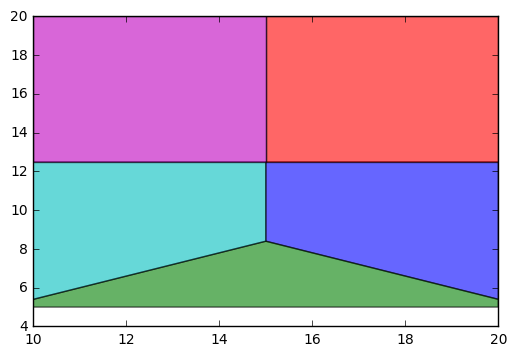

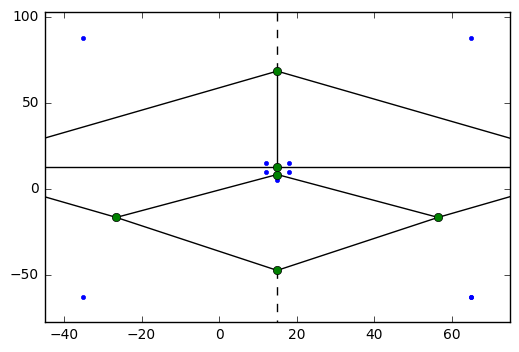

In [4]:
adjacency = get_path('two_image_adjacency.json')
basepath = get_path('Apollo15')
cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)
keypoint_df = pandas.DataFrame({'x': (15, 18, 18, 12, 12), 'y': (5, 10, 15, 15, 10)})
keypoint_matches = [[0, 0, 1, 0],
                    [0, 1, 1, 1],
                    [0, 2, 1, 2],
                    [0, 3, 1, 3],
                    [0, 4, 1, 4]]

matches_df = pandas.DataFrame(data = keypoint_matches, columns = ['source_image', 'source_idx', 
                                                                  'destination_image', 'destination_idx'])
e = edge.Edge()

e.clean = MagicMock(return_value=(matches_df, None))

source_node = MagicMock(spec = node.Node())
destination_node = MagicMock(spec = node.Node())

source_node.get_keypoint_coordinates = MagicMock(return_value=keypoint_df)
destination_node.get_keypoint_coordinates = MagicMock(return_value=keypoint_df)

e.source = source_node
e.destination = destination_node

source_geodata = Mock(spec = io_gdal.GeoDataset)
destination_geodata = Mock(spec = io_gdal.GeoDataset)

e.source.geodata = source_geodata
e.destination.geodata = destination_geodata

source_corners = [(0, 0),
                  (20, 0),
                  (20, 20),
                  (0, 20)]

destination_corners = [(10, 5),
                       (30, 5),
                       (30, 25),
                       (10, 25)]

source_poly = utils.utils.array_to_poly(source_corners)
destination_poly = utils.utils.array_to_poly(destination_corners)

vals = {(10, 5):(10, 5), (20, 5):(20, 5), (20, 20):(20, 20), (10, 20):(10, 20)}

def latlon_to_pixel(i, j):
    return vals[(i, j)]

e.source.geodata.latlon_to_pixel = MagicMock(side_effect = latlon_to_pixel)
e.destination.geodata.latlon_to_pixel = MagicMock(side_effect = latlon_to_pixel)

e.source.geodata.footprint = source_poly
e.source.geodata.xy_corners = source_corners
e.destination.geodata.footprint = destination_poly
e.destination.geodata.xy_corners = destination_corners

source_vor = voronoi(e, 'source', clean_keys=[], verbose = True, k = 10)


voronoi_plot_2d(source_vor[0])

plt.show()

[]
    x   y  weights
0  15   5     19.0
1  18  10     28.0
2  18  15     37.5
3  12  15     37.5
4  12  10     28.0


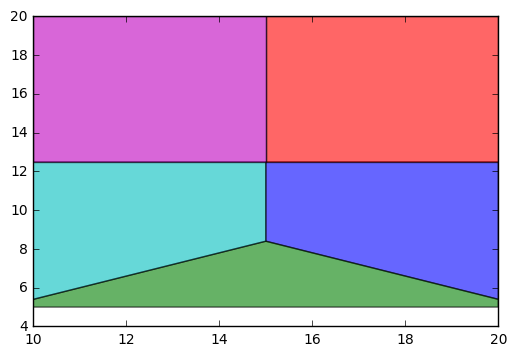

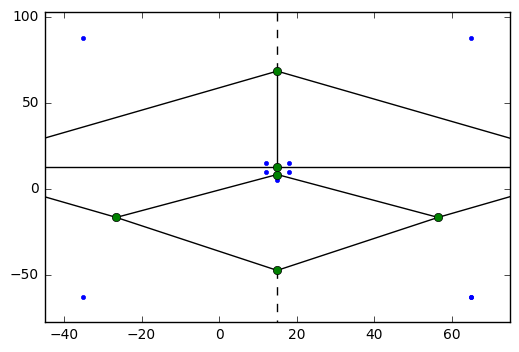

In [5]:
destination_vor = voronoi(e, 'destination', clean_keys=[], verbose = True, k = 10)
voronoi_plot_2d(destination_vor[0])
plt.show()